In [299]:
# BEFORE DOING ANYTHING
# cd Desktop
# git pull

# .. then do stuff ..
# git add .
# git commit -m "your message"
# git push

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import seaborn as sns
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import xgboost as xgb
from xgboost import plot_importance

In [221]:
# The top 10 most important features are:
# How many people the property accommodates
# The cleaning fee
# How many other listings the host has (and whether they are a multi-listing host)
# How many days are available to book out of the next 90
# The fee per extra person
# The number of reviews
# The number of bathrooms
# The security deposit
# If the property is in Westminster
# The minimum nights stay


raw_df = pd.read_csv("listings.csv.gz")
# free text columns will be dropped for now
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [222]:
df.isna().sum()
df.drop(["host_acceptance_rate", "neighbourhood_group_cleansed", "square_feet", "weekly_price", "monthly_price", 
         "license", "jurisdiction_names"], axis=1, inplace=True)

In [223]:
# host_listings_count and host_total_listings_count are the same in all but 16 cases. 
# These cases are those where the value is NaN. Therefore one of these columns can be dropped. 
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:]
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


16


In [224]:
# Since all locations in Los Angeles, drop any columns related to location ie state, country
df["smart_location"].value_counts()
lat_long = df[["latitude", "longitude"]]
df.drop(["zipcode", "state", "country", "country_code", "street", "neighbourhood", "city", "latitude", "longitude", 
         "market", "smart_location", "is_location_exact"], axis=1, inplace= True)

In [225]:
# There are multiple columns for minimum and maximum night stays, 
# but the two main ones will be used as there are few differences between e.g. minimum_nights 
# and minimum_minimum_nights. The default (i.e. most frequently applied) min/max night stay values will be used instead.
sum((df.minimum_nights == df.minimum_minimum_nights) == False)
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], 
          axis=1, inplace=True)

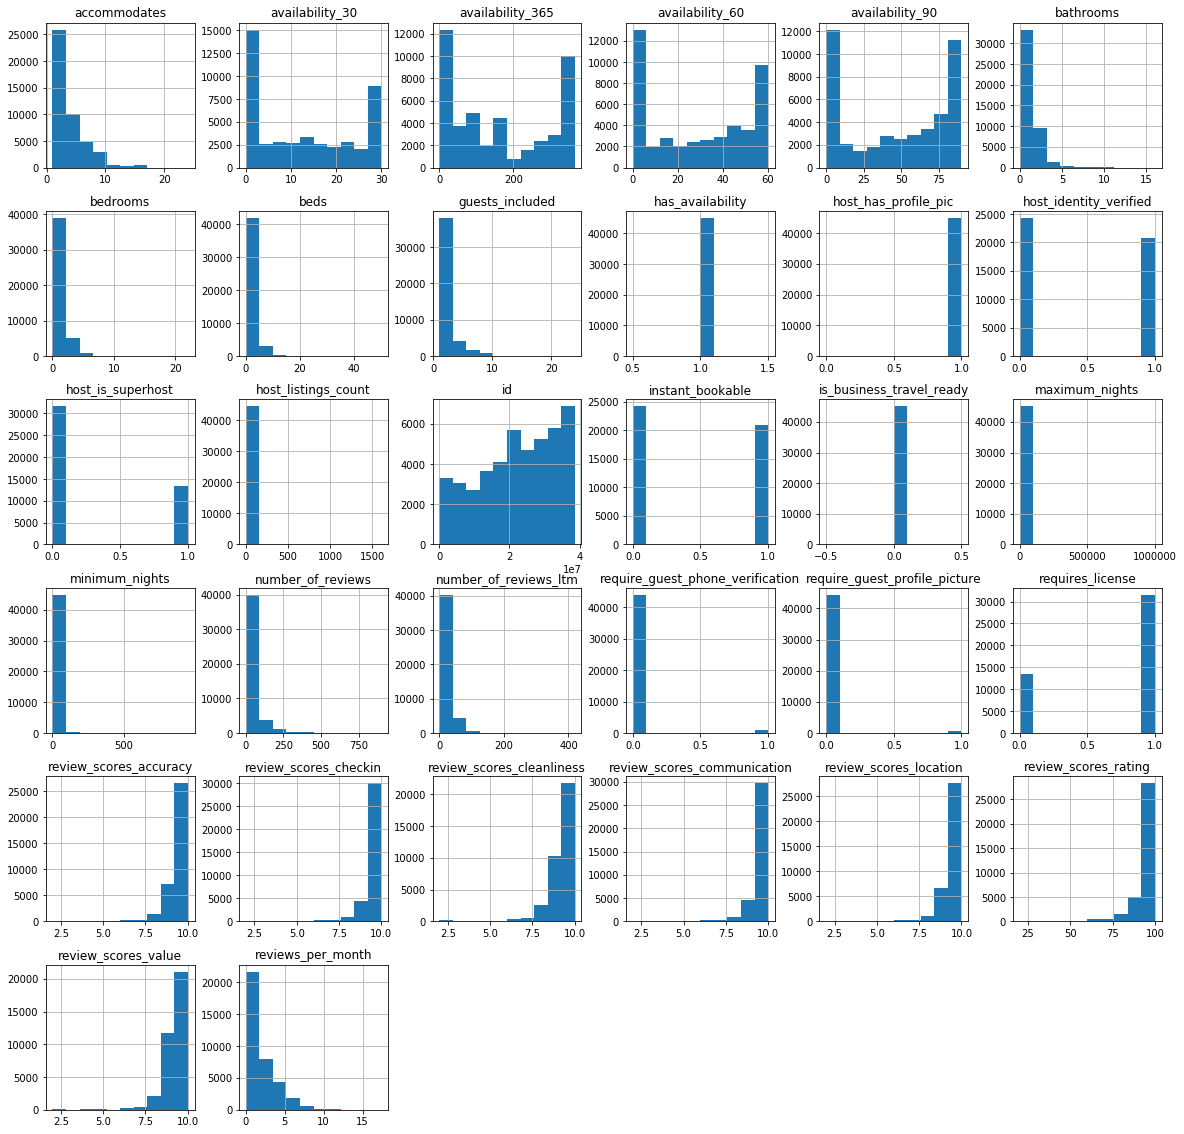

In [226]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [227]:
# Can see above that some boolean categories only contain one category and can be dropped:
df.drop(['has_availability', 'host_has_profile_pic', 'host_listings_count', 'is_business_travel_ready'], axis=1, inplace=True)

In [228]:
# Drop experiences_offered, 
print(df['experiences_offered'].value_counts())
df.drop('experiences_offered', axis=1, inplace=True)

none    45053
Name: experiences_offered, dtype: int64


In [229]:
# Now we're at 44 columns
print(df.shape)

(45053, 44)


In [230]:
###############################
## CLEANING INDIVIDUAL COLS ###
###############################

# host_since
# Converting to date time
df.host_since = pd.to_datetime(df.host_since)

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 9, 14) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)


Mean days as host: 1448.0
Median days as host: 1417.0


In [231]:
# host_response_time

print("Null values:", df.host_response_time.isna().sum())

prop = round((df.host_response_time.isna().sum()/len(df))*100, 1)
print(f"Proportion: {prop}%")

# Number of rows without a value for host_response_time which have also not yet had a review
print(len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2]))

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)


Null values: 8294
Proportion: 18.4%
8519


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


within an hour        0.600293
unknown               0.184094
within a few hours    0.120392
within a day          0.073513
a few days or more    0.021708
Name: host_response_time, dtype: float64

In [232]:
# host_response_rate
df.host_response_rate.value_counts()
print("Null values:", df.host_response_rate.isna().sum())
prop = round((df.host_response_rate.isna().sum()/len(df))*100, 1)
print(f"Proportion: {prop}%")


# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
prop_hund = round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)
print(f"Proportion of 100% host response rates: {prop_hund}%")

Null values: 8294
Proportion: 18.4%
Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.0%


In [233]:
# Bin into 4 categories 
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       25726
unknown     8294
90-99%      5118
50-89%      4566
0-49%       1349
Name: host_response_rate, dtype: int64

In [234]:
# host_is_superhost

df.host_is_superhost.value_counts()

# There are 16 rows lacking values for each of five different host-related features.
# These rows will be dropped 
df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 
                  'host_identity_verified'] ].isnull().sum(axis=1) == 5]

df.dropna(subset=['host_since'], inplace=True)

In [235]:
# property_type

# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

df.property_type.value_counts()

House        19390
Apartment    17872
Other         7775
Name: property_type, dtype: int64

In [236]:
# beds, bathrooms, bedrooms

# Replace missing values with the median
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)
    
# most listings have the same bed_type, so drop this
df.bed_type.value_counts()

df.drop('bed_type', axis=1, inplace=True)

In [237]:
# Amenities is a list of additional features in the property, e.g. whether it has a TV or parking.

# Create a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
# amenities_set

In [238]:
# 44 cols to begin with
print(df.shape)

# Some amenities are more important than others, make new features for these (One Hot Encoding)
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

(45037, 44)


/usr/local/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [239]:
# Start at 44 because cols 44 thru 72 are the new amenity features

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,44:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,44:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'nature_and_views', 'smoking_allowed', 'accessible', 'event_suitable']


In [240]:
df.columns[43:] # All the newly added features that we keep

Index(['air_conditioning', 'bbq', 'balcony', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in'],
      dtype='object')

In [241]:
# price

# Convert to integer
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [242]:
# security_deposit

print(df.security_deposit.isna().sum())

# Having a missing security deposit is equivalent to having $0 security deposit

df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

10903


In [243]:
# cleaning_fee

print(df.cleaning_fee.isna().sum())

# Having a missing cleaning fee is equivalent to having $0 cleaning fee
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

5866


In [244]:
# extra_people

# Having missing value for extra_people is equivalent to 0 extra people allowed
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [245]:
# calendar_updated

df.calendar_updated.value_counts() 
# Unclear as to if this is useful; drop for now
df.drop('calendar_updated', axis=1, inplace=True)

In [246]:
# availability 
# ?? all are highly correlated, which to drop ??

# keep availability_90
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [247]:
# first_review and last_review

# Missing values should be kept as an 'unknown' category, and the feature will have to be treated as categorical 
# (and therefore one-hot encoded) rather than numerical.
# Keep missing values because this means it is probably a new listing !! so there's valuable info

print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 9, 14) - df.first_review).astype('timedelta64[D]')

Null values in 'first_review': 18.9%
Null values in 'review_scores_rating': 20.2%


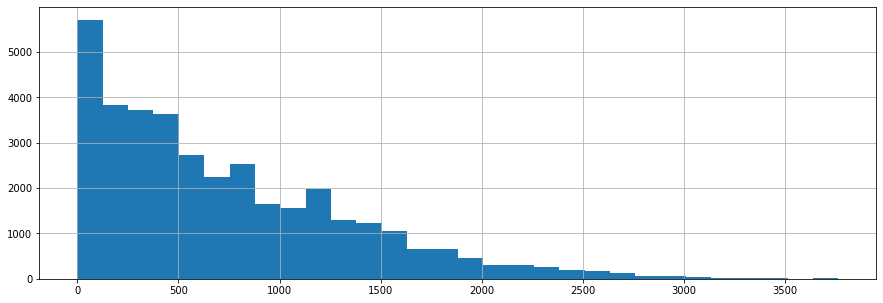

In [248]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [249]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)
    

In [250]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [251]:
# Do the same for last_review
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 9, 14) - df.last_review).astype('timedelta64[D]')

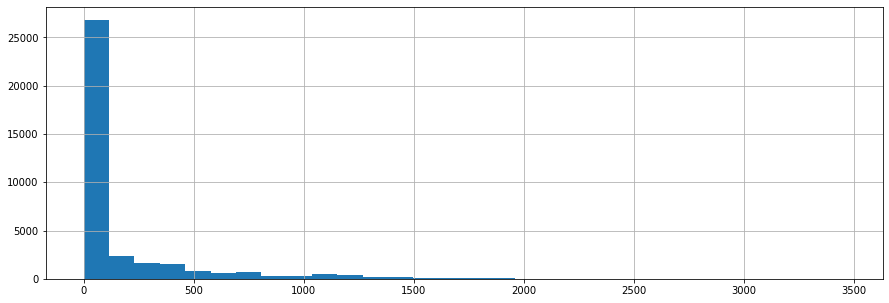

In [252]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [253]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [254]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,time_since_first_review,time_since_last_review
0,109,2008-06-27,unknown,unknown,0.0,1.0,Culver City,Other,Entire home/apt,6,2.0,2.0,3.0,122,500,240,3,25,30,730,0,2,0,2011-08-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,0,0,strict_14_with_grace_period,1,0,0.02,4096.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,4+ years,1+ year
1,344,2008-07-11,within a day,0-49%,0.0,1.0,Burbank,House,Entire home/apt,6,1.0,3.0,3.0,168,0,100,6,0,2,14,0,6,1,2016-06-14,93.0,10.0,10.0,10.0,10.0,10.0,9.0,0,1,flexible,0,0,0.15,4082.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2-3 years,6-12 months
2,2708,2008-09-16,within an hour,100%,1.0,1.0,Hollywood,Apartment,Private room,1,1.5,1.0,1.0,79,480,87,1,0,28,366,1,21,8,2014-06-09,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,strict_14_with_grace_period,0,0,0.33,4015.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4+ years,2-8 weeks
3,2732,2008-09-17,within an hour,100%,1.0,0.0,Santa Monica,Apartment,Private room,1,1.0,1.0,1.0,140,0,100,1,0,1,180,71,19,2,2011-06-06,96.0,9.0,9.0,10.0,10.0,10.0,9.0,1,0,strict_14_with_grace_period,0,0,0.19,4014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4+ years,2-8 weeks
4,2864,2008-09-25,unknown,unknown,0.0,1.0,Bellflower,Apartment,Entire home/apt,2,1.0,1.0,1.0,80,100,75,1,25,2,730,0,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,strict_14_with_grace_period,0,0,NaN,4006.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45048,38603385,2018-04-14,unknown,unknown,0.0,0.0,Reseda,House,Private room,1,1.0,0.0,1.0,89,0,0,1,0,1,1125,83,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,flexible,0,0,NaN,518.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,nan,nan
45049,38603626,2016-08-15,within an hour,100%,1.0,1.0,Sun Valley,Apartment,Private room,2,1.0,1.0,1.0,90,0,25,1,0,3,1125,90,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,0,0,NaN,1125.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,nan,nan
45050,38603645,2015-03-22,unknown,unknown,0.0,0.0,Pasadena,House,Private room,2,1.0,1.0,2.0,47,0,0,1,0,1,1125,72,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,0,0,NaN,1637.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,nan,nan
45051,38604183,2016-01-16,within an hour,90-99%,0.0,0.0,Venice,Apartment,Entire home/apt,3,1.0,1.0,1.0,105,500,115,1,0,30,1125,73,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,strict_14_with_grace_period,0,0,NaN,1337.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,nan,nan


In [255]:
df.drop(['time_since_first_review', 'time_since_last_review'], axis=1, inplace=True)

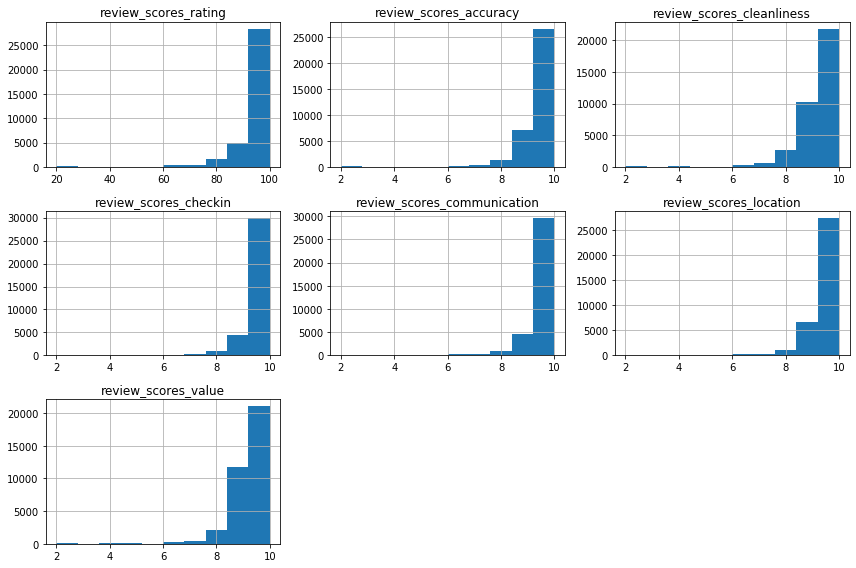

In [256]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [257]:
variables_to_plot.pop(0)

'review_scores_rating'

In [258]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [259]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [260]:
# cancellation_policy
df.cancellation_policy.value_counts()

# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate',
    'luxury_no_refund': 'strict'
    }, inplace=True)

In [261]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [262]:
df.drop('host_since', axis=1, inplace=True)

In [263]:
df.drop('first_review', axis=1, inplace=True)

In [265]:

# Replacing other categories with 'other'
#df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
values = df['neighbourhood_cleansed'].value_counts().keys().to_list()
counts = df['neighbourhood_cleansed'].value_counts().to_list()

low_values = []
for c in range(len(counts)):
    if counts[c] < 50:
        print(values[c])
        low_values.append(values[c])

# Replacing other categories with 'other'
df.loc[df.neighbourhood_cleansed.isin(low_values), 'neighbourhood_cleansed'] = 'Other'

df

Norwalk
Industry
Agoura Hills
South San Gabriel
Covina
La Verne
Beverlywood
Sylmar
South Park
Signal Hill
Pico Rivera
Baldwin Park
Montebello
Del Aire
Elysian Valley
Shadow Hills
La Mirada
Wilmington
La Cañada Flintridge
San Dimas
West Carson
Lomita
Century City
Panorama City
Watts
Porter Ranch
Bellflower
Central-Alameda
Tujunga
Elysian Park
Harbor City
Cypress Park
South Gate
La Crescenta-Montrose
La Habra Heights
Duarte
Cerritos
Griffith Park
Unincorporated Catalina Island
Manchester Square
Mayflower Village
Castaic Canyons
Gramercy Park
Lennox
South Whittier
Castaic
Lynwood
Sierra Madre
Chesterfield Square
Westmont
North El Monte
Compton
Veterans Administration
Valinda
Pacoima
Florence-Firestone
San Pasqual
Vermont-Slauson
Palos Verdes Estates
San Marino
Stevenson Ranch
Mission Hills
Sunland
Vermont Knolls
Avocado Heights
La Puente
Agua Dulce
Paramount
Alondra Park
Broadway-Manchester
Westlake Village
Charter Oak
West Puente Valley
South El Monte
San Fernando
Arleta
Willowbrook
Sout

,id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in
0,109,unknown,unknown,0.0,1.0,Culver City,Other,Entire home/apt,6,2.0,2.0,3.0,122,500,240,3,25,30,730,0,2,0-79/100,10/10,10/10,0-8/10,0-8/10,10/10,0-8/10,0,0,strict_14_with_grace_period,1,0,4096.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,344,within a day,0-49%,0.0,1.0,Burbank,House,Entire home/apt,6,1.0,3.0,3.0,168,0,100,6,0,2,14,0,6,80-94/100,10/10,10/10,10/10,10/10,10/10,9/10,0,1,flexible,0,0,4082.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2708,within an hour,100%,1.0,1.0,Hollywood,Apartment,Private room,1,1.5,1.0,1.0,79,480,87,1,0,28,366,1,21,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,1,1,strict_14_with_grace_period,0,0,4015.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2732,within an hour,100%,1.0,0.0,Santa Monica,Apartment,Private room,1,1.0,1.0,1.0,140,0,100,1,0,1,180,71,19,95-100/100,9/10,9/10,10/10,10/10,10/10,9/10,1,0,strict_14_with_grace_period,0,0,4014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2864,unknown,unknown,0.0,1.0,Other,Apartment,Entire home/apt,2,1.0,1.0,1.0,80,100,75,1,25,2,730,0,0,nan,nan,nan,nan,nan,nan,nan,0,0,strict_14_with_grace_period,0,0,4006.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45048,38603385,unknown,unknown,0.0,0.0,Reseda,House,Private room,1,1.0,0.0,1.0,89,0,0,1,0,1,1125,83,0,nan,nan,nan,nan,nan,nan,nan,1,0,flexible,0,0,518.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
45049,38603626,within an hour,100%,1.0,1.0,Sun Valley,Apartment,Private room,2,1.0,1.0,1.0,90,0,25,1,0,3,1125,90,0,nan,nan,nan,nan,nan,nan,nan,1,1,flexible,0,0,1125.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
45050,38603645,unknown,unknown,0.0,0.0,Pasadena,House,Private room,2,1.0,1.0,2.0,47,0,0,1,0,1,1125,72,0,nan,nan,nan,nan,nan,nan,nan,1,1,flexible,0,0,1637.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
45051,38604183,within an hour,90-99%,0.0,0.0,Venice,Apartment,Entire home/apt,3,1.0,1.0,1.0,105,500,115,1,0,30,1125,73,0,nan,nan,nan,nan,nan,nan,nan,1,1,strict_14_with_grace_period,0,0,1337.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [266]:
df.drop('neighbourhood_cleansed', axis=1, inplace=True)


In [268]:
df.drop(['review_scores_communication', 'cooking_basics', 'child_friendly', 'coffee_machine', 
         'outdoor_space', 'host_greeting', 'require_guest_profile_picture', 'secure', 
         'require_guest_phone_verification'], axis=1, inplace= True)

### Preparing the data for modeling

In [270]:
df
transformed_df = pd.get_dummies(df)

## Do heatmap later, possibly drop some






In [271]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'beds', 'bedrooms','cleaning_fee', 'extra_people', 
                     'host_days_active', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [216]:
transformed_df

,id,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_checkin_nan,review_scores_communication_0-8/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_communication_nan,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_nan,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,time_since_last_review_nan
0,109,0.0,1.0,1.791759,0.693147,0.693147,1.098612,4.804021,6.214608,5.480639,3,3.218876,3.401197,6.593045,0,0.693147,0,0,1,0,4096.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,344,0.0,1.0,1.791759,0.000000,1.098612,1.098612,5.123964,-4.605170,4.605170,6,-4.605170,0.693147,2.639057,0,1.791759,0,1,0,0,4082.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,2708,1.0,1.0,0.000000,0.405465,0.000000,0.000000,4.369448,6.173786,4.465908,1,-4.605170,3.332205,5.902633,1,3.044522,1,1,0,0,4015.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
3,2732,1.0,0.0,0.000000,0.000000,0.000000,0.000000,4.941642,-4.605170,4.605170,1,-4.605170,0.000000,5.192957,71,2.944439,1,0,0,0,4014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
4,2864,0.0,1.0,0.693147,0.000000,0.000000,0.000000,4.382027,4.605170,4.317488,1,3.218876,0.693147,6.593045,0,-4.605170,0,0,0,0,4006.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1

## XGBoost 

In [281]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price
print(np.exp(y))

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

0        122.0
1        168.0
2         79.0
3        140.0
4         80.0
         ...  
45048     89.0
45049     90.0
45050     47.0
45051    105.0
45052     28.0
Name: price, Length: 45037, dtype: float64


In [273]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:07:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.2 minutes

Training MSE: 0.1887
Validation MSE: 0.1827

Training r2: 0.7529
Validation r2: 0.757


In [284]:
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print(np.exp(val_preds_xgb_reg))
print(np.exp(y_test))

[  94.89442   109.47548  2160.7563   ...   69.27786    54.883656
   98.97933 ]
3551       79.0
21623     150.0
26739    1950.0
18843      60.0
2492       88.0
          ...  
19592     105.0
35259     299.0
14359      66.0
2803       45.0
40017     105.0
Name: price, Length: 9008, dtype: float64


In [274]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg


,weight
host_response_rate_0-49%,0.000000
host_response_time_a few days or more,0.000000
host_response_time_within a day,0.000000
cancellation_policy_strict,0.000000
host_response_rate_50-89%,0.000000
host_response_rate_unknown,0.000000
property_type_Other,0.000000
review_scores_rating_0-79/100,0.000000
review_scores_rating_95-100/100,0.000000
review_scores_rating_nan,0.000000


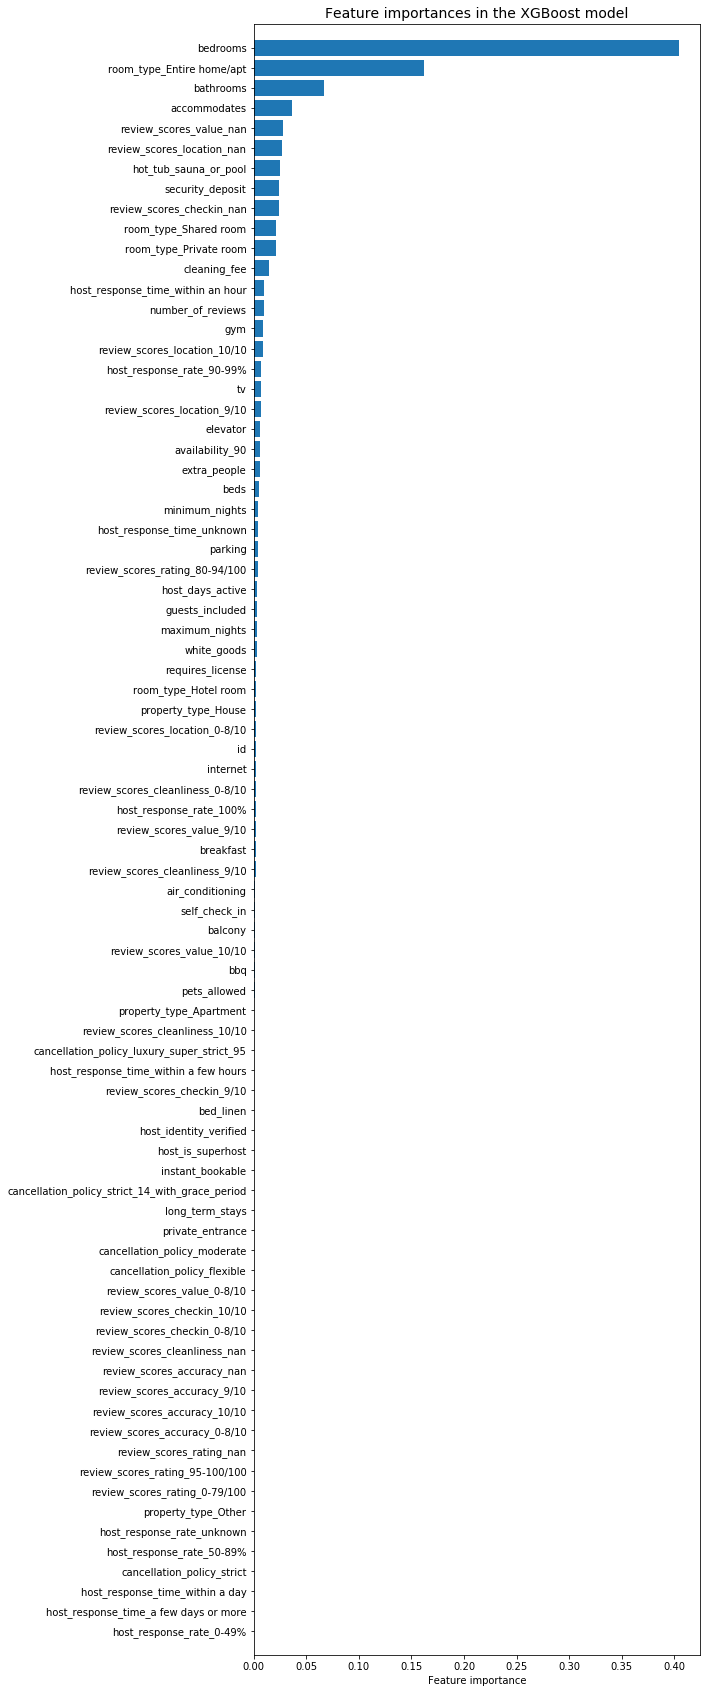

In [275]:
# Plotting feature importances
plt.figure(figsize=(8,30))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [301]:

# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
# SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               10368     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_35 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total params: 109,441
Trainable params: 109,441
Non-trainable params: 0
_________________________________________________________________
None


In [302]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Train on 32426 samples, validate on 3603 samples
Epoch 1/100
32426/32426 [==============================] - 2s 57us/step - loss: 1.1983 - mean_squared_error: 1.1983 - val_loss: 0.2868 - val_mean_squared_error: 0.2868
Epoch 2/100
32426/32426 [==============================] - 1s 44us/step - loss: 0.2764 - mean_squared_error: 0.2764 - val_loss: 0.2499 - val_mean_squared_error: 0.2499
Epoch 3/100
32426/32426 [==============================] - 1s 40us/step - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2213 - val_mean_squared_error: 0.2213
Epoch 4/100
32426/32426 [==============================] - 1s 38us/step - loss: 0.2217 - mean_squared_error: 0.2217 - val_loss: 0.2130 - val_mean_squared_error: 0.2130
Epoch 5/100
32426/32426 [==============================] - 1s 45us/step - loss: 0.2082 - mean_squared_error: 0.2082 - val_loss: 0.2081 - val_mean_squared_error: 0.2081
Epoch 6/100
32426/32426 [==============================] - 1s 38us/step - loss: 0.1994 - mean_squared_error: 0.

32426/32426 [==============================] - 1s 34us/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.2507 - val_mean_squared_error: 0.2507
Epoch 50/100
32426/32426 [==============================] - 1s 37us/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.2468 - val_mean_squared_error: 0.2468
Epoch 51/100
32426/32426 [==============================] - 1s 35us/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.2411 - val_mean_squared_error: 0.2411
Epoch 52/100
32426/32426 [==============================] - 1s 40us/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.2409 - val_mean_squared_error: 0.2409
Epoch 53/100
32426/32426 [==============================] - 1s 33us/step - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.2504 - val_mean_squared_error: 0.2504
Epoch 54/100
32426/32426 [==============================] - 2s 48us/step - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.2489 - val_mean_squared_error: 0.2489

32426/32426 [==============================] - 1s 32us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.2590 - val_mean_squared_error: 0.2590
Epoch 98/100
32426/32426 [==============================] - 1s 35us/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.2492 - val_mean_squared_error: 0.2492
Epoch 99/100
32426/32426 [==============================] - 1s 35us/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.2495 - val_mean_squared_error: 0.2495
Epoch 100/100
32426/32426 [==============================] - 1s 30us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.2511 - val_mean_squared_error: 0.2511
Time taken to run: 2.3 minutes


In [303]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0385
Validation MSE: 0.2716

Training r2: 0.9496
Validation r2: 0.6387


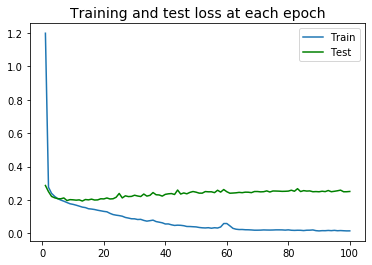

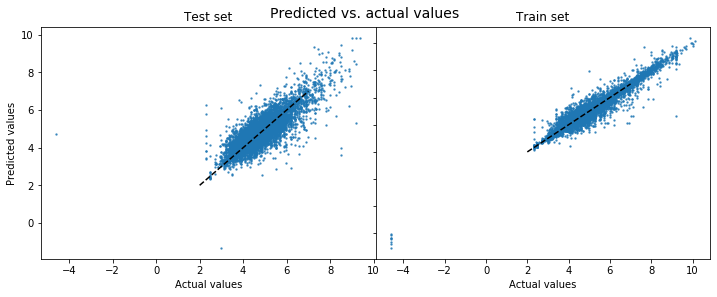

In [304]:
nn_model_evaluation(nn2)
